In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np #adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import pandas as pd #data structures and operations for manipulating numerical tables and time series
import sys # system path io
import glob #glob module is used to retrieve files/pathnames matching a specified pattern
from tqdm import tqdm # show progress bar when a loop is running
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly import tools
from plotly.graph_objs import *
from plotly.graph_objs.layout import Margin, YAxis, XAxis
init_notebook_mode()
import matplotlib.pyplot as plt
from matplotlib import patches as patches
import os
from pathlib import Path
import xml.etree.ElementTree as ET
import io

#input_dir = Path('../input/feline-reticulocytes')
#data_dir = input_dir / 'data_300x300'
#os.listdir(data_dir)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = '/content/gdrive/MyDrive/data_300x300/data_300x300/images'

Mounted at /content/gdrive


First, I need to read the xml file tags to a panda
the following function was done with some help from : 
https://www.kaggle.com/aakashnain/eda2modelling-tf-object-detection-api

In [ ]:
# A function to parse the xmls
def parse_xmls(xml_files):
    data = []
    # Iterate over each file
    for sample in xml_files:
        # Get the xml tree
        tree = ET.parse(sample)

        # Get the root
        root = tree.getroot()

        # Get the members and extract the values
        for member in root.findall('object'):
            # Name of the image file
            filename =root.find('filename').text
            # Bounding box coordinates
            bndbox = member.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            xmax = float(bndbox.find('xmax').text)
            ymin = float(bndbox.find('ymin').text)
            ymax = float(bndbox.find('ymax').text)
            
            # label to the corresponding bounding box
            label =  member.find('name').text

            data.append((filename, label, xmin, ymin, xmax, ymax))
    
    # Create a pandas dataframe
    columns_name = ['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    df = pd.DataFrame(data=data, columns=columns_name)

    return df

###**Make sure that there's an annotation file for every image instance**

In [ ]:

import glob #glob module is used to retrieve files/pathnames matching a specified pattern
images = sorted(glob.glob('/content/gdrive/MyDrive/data_300x300/data_300x300/images/*.jpg'))
xmls = sorted(glob.glob('/content/gdrive/MyDrive/data_300x300/data_300x300/labels/*.xml'))
print("Total number of images: ", len(images))
print("Total number of xmls: ", len(xmls))
retic_df = parse_xmls(xmls)
retic_df.head(20)


Total number of images:  1086
Total number of xmls:  1086


filename                   class   xmin   ymin   xmax   ymax
0   000045.jpg  aggregate reticulocyte  140.0  115.0  169.0  143.0
1   000045.jpg   punctate reticulocyte   72.0  155.0  103.0  187.0
2   000045.jpg             erythrocyte  184.0  195.0  213.0  228.0
3   000058.jpg             erythrocyte  174.0   65.0  203.0   94.0
4   000058.jpg  aggregate reticulocyte  120.0  113.0  151.0  143.0
5   000058.jpg             erythrocyte  169.0  178.0  197.0  207.0
6   000061.jpg   punctate reticulocyte    8.0  100.0   42.0  134.0
7   000061.jpg   punctate reticulocyte   43.0   92.0   76.0  126.0
8   000061.jpg             erythrocyte  116.0   73.0  149.0  102.0
9   000061.jpg  aggregate reticulocyte  165.0  163.0  196.0  193.0
10  000078.jpg   punctate reticulocyte   41.0   68.0   75.0  103.0
11  000078.jpg             erythrocyte   81.0  187.0  110.0  220.0
12  000078.jpg  aggregate reticulocyte  246.0  127.0  278.0  157.0
13  000078.jpg             erythrocyte  271.0  149.0  300.0  178.0
14  000087.jpg   punctate reticulocyte    2.0  181.0   34.0  214.0
15  000087.jpg             erythrocyte   66.0  121.0   97.0  158.0
16  000087.jpg  aggregate reticulocyte  179.0  126.0  210.0  157.0
17  000093.jpg   punctate reticulocyte   30.0  152.0   60.0  188.0
18  000093.jpg             erythrocyte  220.0  129.0  251.0  165.0
19  000093.jpg  aggregate reticulocyte  230.0  165.0  260.0  194.0

###**# EDA1 : Some random samples**

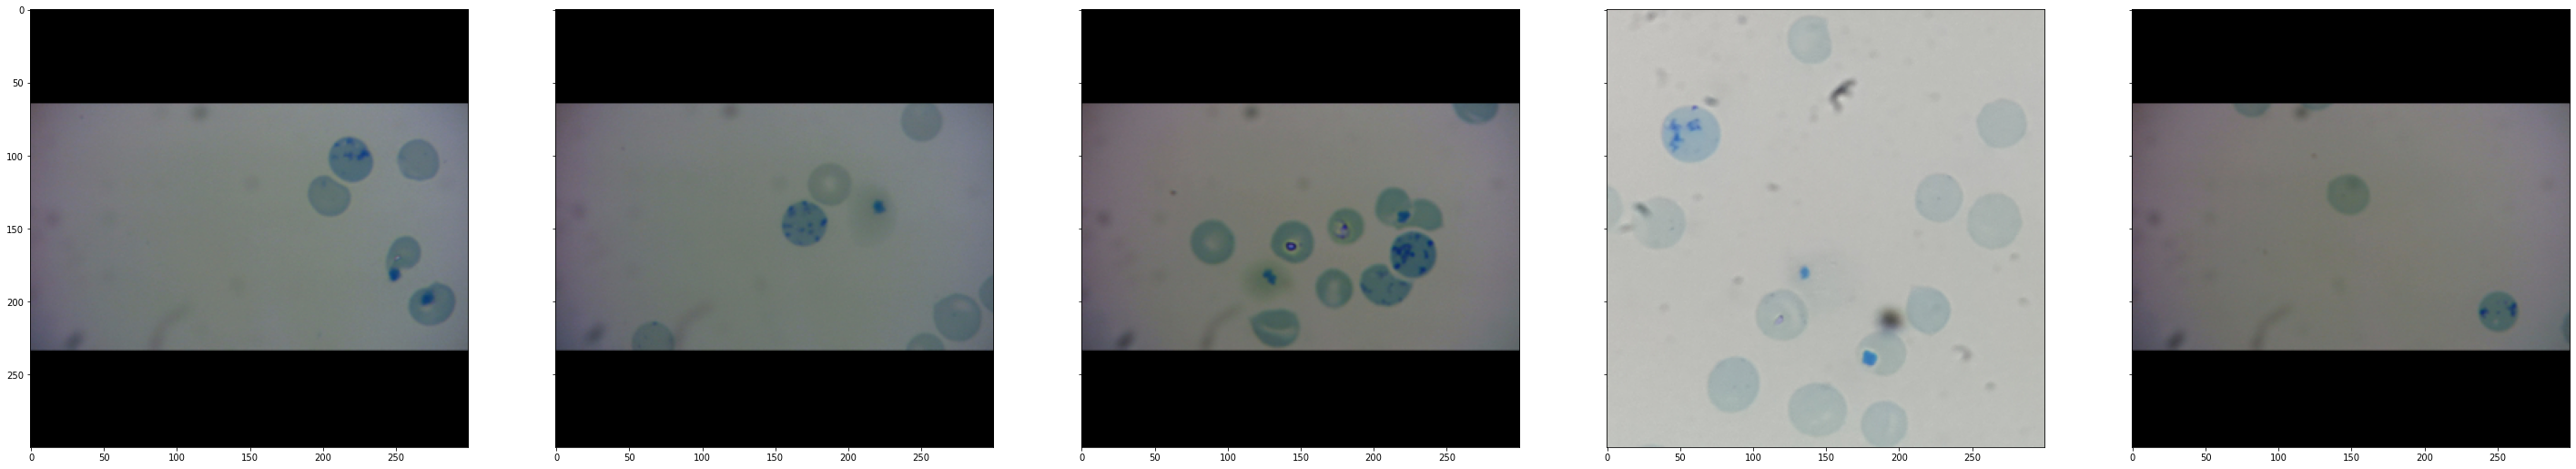

In [ ]:

from numpy import asarray
from PIL import Image
num_img = 5
subplot_count = 0
fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10)) #cz we're showing 4 subplots in the figure!   Share the Y axis! the X axis is a proportion of the number of images!
for index, row in retic_df.sample(n=num_img).iterrows(): # get a random sample of 4 images
    dataset = asarray(Image.open('/content/gdrive/MyDrive/data_300x300/data_300x300/images/' + row['filename']))
    ax[subplot_count].imshow(dataset) 
    subplot_count += 1

**Run multiple times **
1.   The first observation: that some instances are full images , some others have black triangles on the top and bottom 
Actions: this noise might be useful and help the network better generlize but it might also create an undesirable bias.

2.   The 2nd Observation: multiple cells appear in each instance, so we must check if multiple annotations exist for each instance 
**bold text**








In [ ]:
import cv2
def plot_with_bbox(imagename,sample_df, figsize=(20,10)):
    #print(sample_df, "\n\n")
     
    img = cv2.imread('/content/gdrive/MyDrive/data_300x300/data_300x300/images/' + imagename)
    Or_img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,5))
    ax[0].imshow(Or_img)
    ax[1].imshow(final)
    ax[1].set_title('Instances after applying CLAHE')
    for index, row in sample_df.iterrows():
       xmin = row["xmin"]
       xmax = row["xmax"]
       ymin = row["ymin"]
       ymax = row["ymax"]
       bbox = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none')
       ax[0].add_patch(bbox)
       ax[0].set_title('Instances with bounding boxes')
    plt.show() 

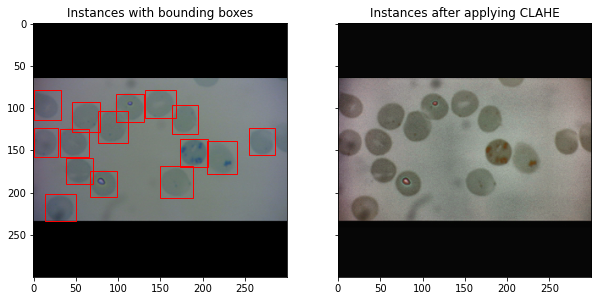

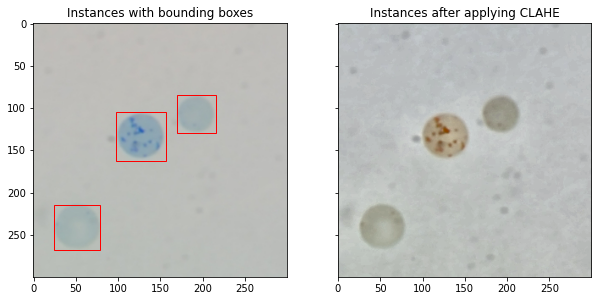

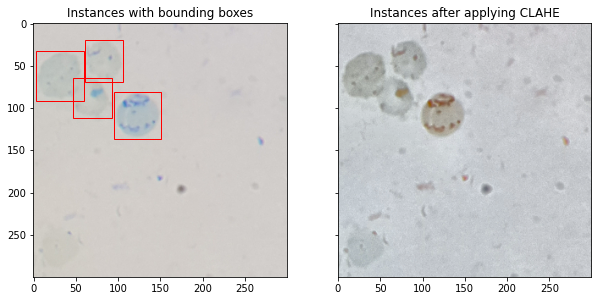

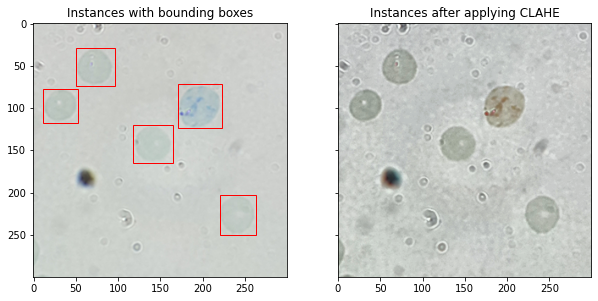

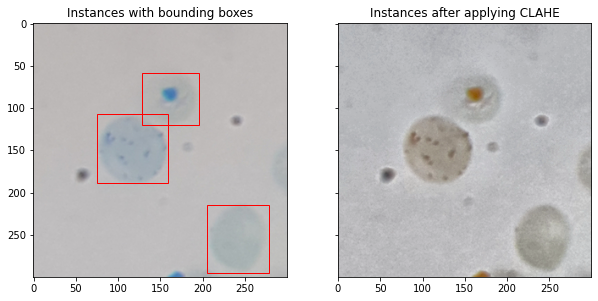

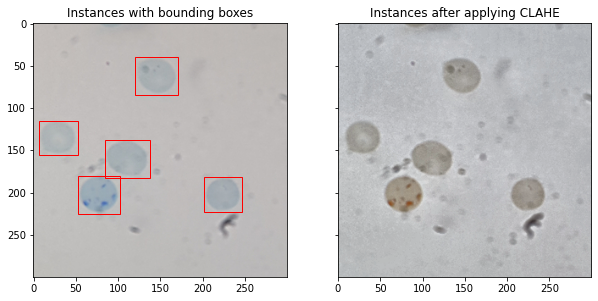

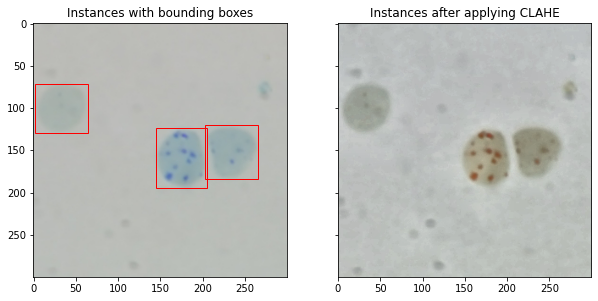

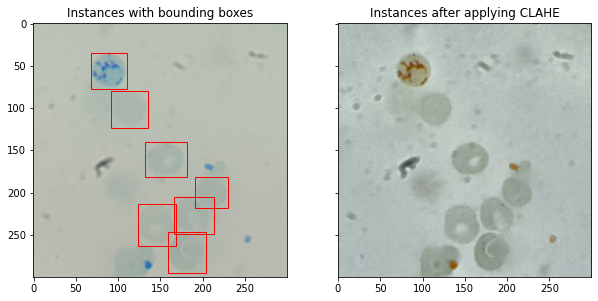

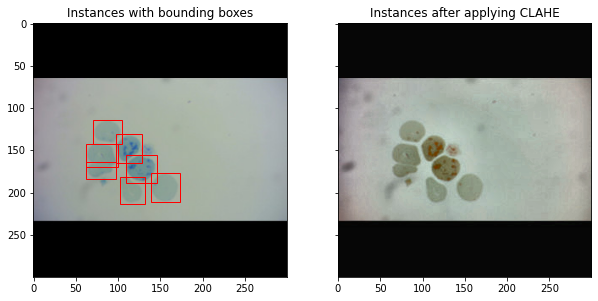

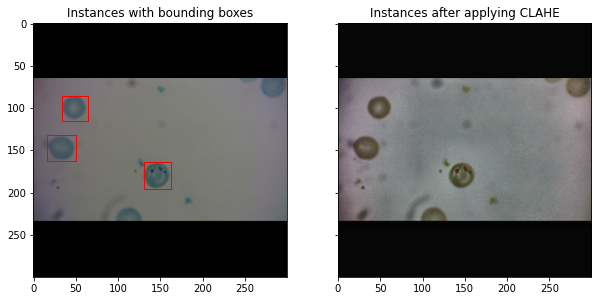

In [ ]:
#EDA2: plot instances with BB on them to explore the ROIs
#the dataset is now grouped by file names, because multiple ROIs might exit in each instance
Retic_data_grouped=retic_df.groupby(["filename"])
#choose 10 random samples to plot with BB
train_sample = retic_df["filename"].sample(10)
train_sample.columns=["filename"]
for instance in train_sample.values:
    plot_with_bbox(instance, Retic_data_grouped.get_group(instance))

* Observation 3: Multiple bounding boxes might exist in each instance
* Observation 4: Cells might overlap
* Observation 5: Some cells are not annotated
* Observation 6: CLAHE made the edges much more visible
===============================
* Observation 7: Seems that the authors used multiple magnifications?because not all cells fall in the same size range
* Question: Does training the network on greyscale images help the network overcome the cross-stain issue?

In [ ]:
#EDA 3: Any BB without a label? or a label other than the designated Classes in the labels space? The answer is no
print(retic_df["class"].unique())

['aggregate reticulocyte' 'punctate reticulocyte' 'erythrocyte']


aggregate reticulocyte :  1001
punctate reticulocyte :  1007
erythrocyte :  1982


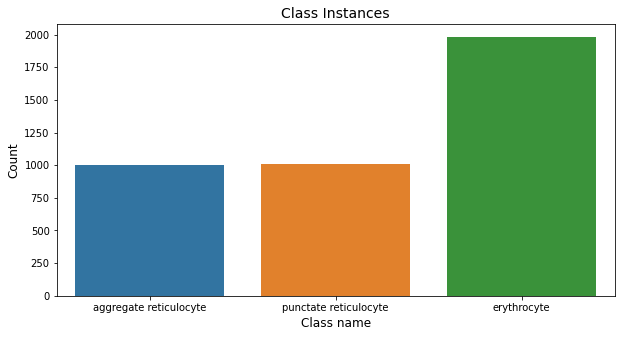

In [ ]:
#EDA 4:Count class instances 

import seaborn as sns
Classes_list = []
# can also use groupby
for class_name in retic_df["class"].unique():
    class_count= retic_df[retic_df["class"] == class_name]["class"].count()
    print(class_name, ": ",class_count)
    Classes_list.append(class_count)
x = retic_df["class"].unique()
y = Classes_list
plt.figure(figsize=(10,5))
sns.barplot(x=x, y=y)
plt.title('Class Instances', fontsize=14)
plt.xlabel('Class name', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

Observation 8: There's a slight imbalance in the dataset, the number of RBCs (erythrocyte) is more than the other two classes

* for each bounding box , find the diff in Y and the area of the circle, then group them based on the class, plot in box view each
* class to see the average size and find outliers
* Suppose that the BB delta Y is the diameter of the cell,and find the APPROXIMATE cell area based on that
* Here we are not intereseted in the exact measurment, like how many inches or cm the radius is, we are only interested in knowing 
* how the sizes of the cells are compared to each other

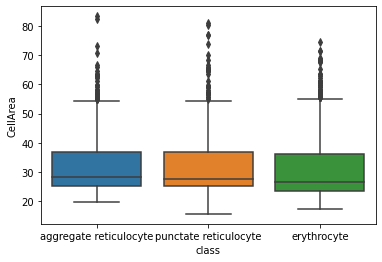

In [ ]:
import math
retic_df["CellArea"] = (math.pi/4) *(retic_df["ymax"] -retic_df["ymin"])
ax2 = sns.boxplot(x="class", y="CellArea", data=retic_df)
